In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import sympy
from sklearn import preprocessing


Bad key "text.kerning_factor" on line 4 in
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average
K = 4 # controls number of restarts

np.random.seed(0)
random.seed(42)

In [3]:
with open('citeseer/citeseer.content') as f:
    lines = f.readlines()
    
ne = preprocessing.LabelEncoder() 
ce = preprocessing.LabelEncoder()
nodes_list = [line.strip().split() for line in lines]

In [4]:
nodes = [n[0] for n in nodes_list]
classes = [n[-1] for n in nodes_list]
nodes = ne.fit_transform(nodes+['XYZA'])
classes = ce.fit_transform(classes+['XYZA'])

In [5]:
G = nx.Graph()
for i,j in enumerate(nodes):
    G.add_node(nodes[i],classes = classes[i])

In [6]:
with open('citeseer/citeseer.cites') as f:
    lines = f.readlines()

def replace(star):
    if star in ne.classes_:
        return star
    return 'XYZA'

edges_list = [line.strip().split() for line in lines]
edges_0 = ne.transform([replace(x[0]) for x in edges_list])
edges_1 = ne.transform([replace(x[1]) for x in edges_list])
edges = [(a,b) for a,b in zip(edges_0,edges_1)]

In [7]:
G.add_edges_from(edges)

In [8]:
print(G.number_of_edges(),G.number_of_nodes())
G = max(nx.connected_component_subgraphs(G), key=len)

4675 3313


Modularity for best partition: 0.8519535997200952


/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


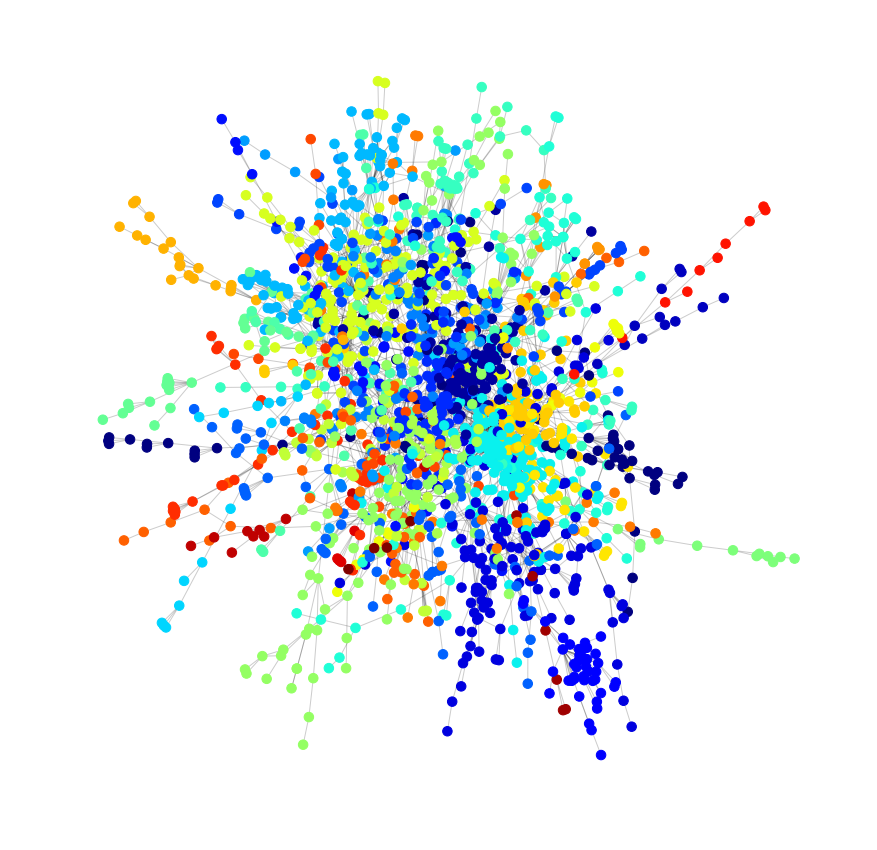

In [9]:
from louvain import detect_communities, modularity
def draw_communities(G, node_size=90, alpha=1, k=None, randomized=False):
    partition = detect_communities(G, randomized=randomized)
    print("Modularity for best partition:", modularity(G, partition))
    community_map = {}
    for community, nodes in enumerate(partition):
        for node in nodes:
            community_map[node] = community
    
    cmap = plt.get_cmap("jet")
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=k)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
    #for x in range(len(pos)):
    #    print(pos)
    #    pos[x] = pos[x]+np.array([0.02,0])
    #labels = dict([(n, n) for n in G.nodes()]) #add labels
    #_ = nx.draw_networkx_labels(G, pos, labels=labels, font_color='#000000', font_size=15) #draw labels

draw_communities(G)

In [10]:
partition = detect_communities(G, randomized=False)
community_map = {}
node_map = {}

for community, nodes in enumerate(partition):
    for node in nodes:
        node_map[node] = community
    community_map[community] = nodes

G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()

print(nx.is_connected(G),G_no_edges,G_no_nodes)

True 3751 2129


In [11]:
def MH_sampling(G,B):
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample_t = np.random.choice(neighbors)
        if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
            sample = sample_t
        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

def RDS_sampling(G,B):
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample = np.random.choice(neighbors)
        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [12]:
def RDSRR_sampling(G,B,U=None):
    #M = np.power(B,2/3)
    #restart_ind = np.power(np.arange(1,M),1.5)
    restart_ind = [10]
    t=20
    while restart_ind[-1]<B:
        restart_ind.append(restart_ind[-1]+int(80*np.log(t)))
        t+=1
    
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample = np.random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

def MHRR_sampling(G,B,U=None):
    #M = np.power(B,2/3)
    #restart_ind = np.power(np.arange(1,M),1.5)
    restart_ind = [10]
    t=20
    while restart_ind[-1]<B:
        restart_ind.append(restart_ind[-1]+int(K*np.log(t)))
        t+=1
    
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample_t = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

## F(v) = int(node_map[node] == 1)

In [13]:
def node_fn(node):
    return int(node_map[node]==1)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.054015969938938466


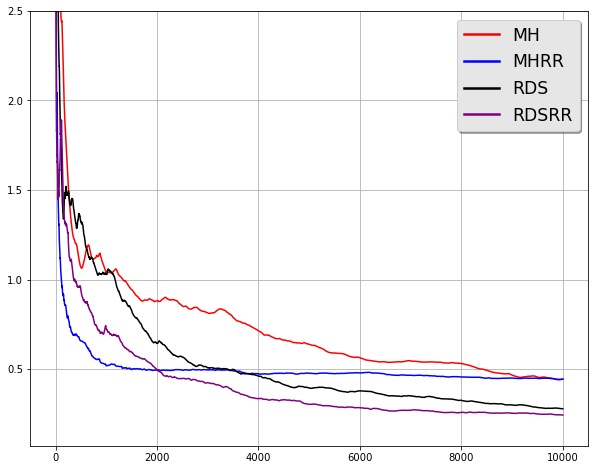

In [14]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MH')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDS')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR')
plt.ylim(top=2.5)

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.grid()

## F(v) = int(G.degree(node)>10)

In [15]:
def node_fn(node):
    return int(G.degree(node)>10)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.03945514325974636


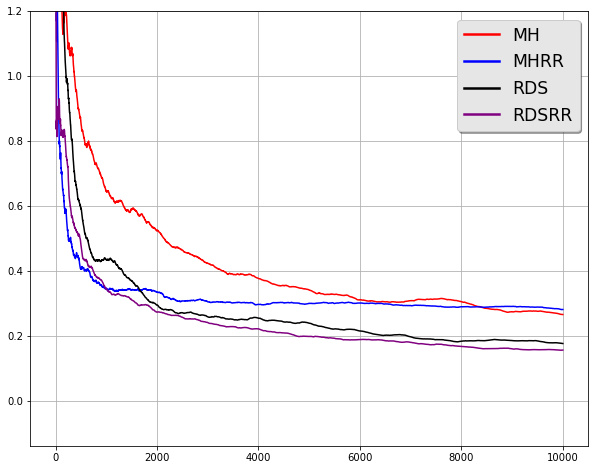

In [16]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MH')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDS')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR')
plt.ylim(top=1.2)

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.grid()

## F(v) = isprime(v)

In [17]:
def node_fn(node):
    return int(sympy.isprime(G.degree(node)))
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.5364020666979803


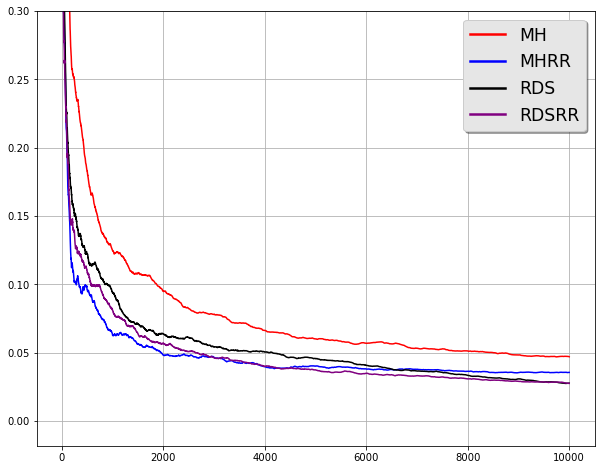

In [18]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MH')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDS')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR')
plt.ylim(top=0.3)

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.grid()

## F(v) = (R(v)+1) x (1+Node_map[v])

In [19]:
def node_fn(node):
    return (1+G.node[node]['classes'])*(1+node_map[node])

F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

56.59981211836543


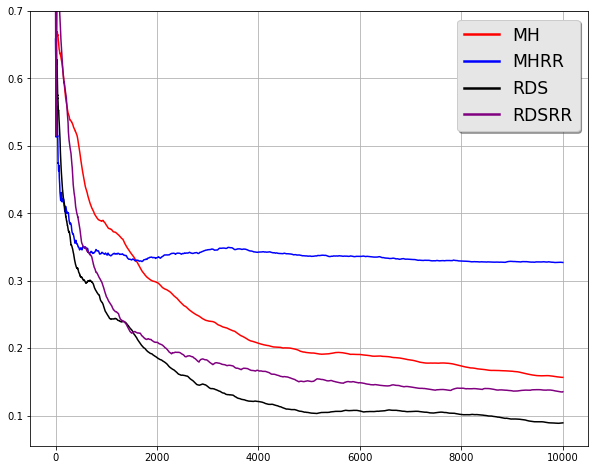

In [20]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MH')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDS')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR')
plt.ylim(top=0.7)

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.grid()

## F(v) = random(v)

In [21]:
fn_mapping = np.random.exponential(1,size=(G_no_nodes))
def node_fn(node):
    return fn_mapping[G.nodes().index(node)]

F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)    

0.9954489140985855


In [ ]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MH')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDS')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR')

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.ylim(top = 0.3)
plt.grid()